# Exploring the data set 

## Image sizes 

In [10]:
# Imports 
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np 
import random

In [2]:
# Define the directory containing images
image_dir = '/home/walid/Desktop/OpenCv/Malaria-detection/train'

# Initialize lists to store image resolutions
resolutions = []

# Loop through all images in the directory
for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    
    # Check if the file is an image
    if os.path.isfile(image_path):
        # Read the image
        image = cv2.imread(image_path)
        
        if image is not None:
            # Get image resolution
            height, width, _ = image.shape
            resolution = f"{width}x{height}"
            
            # Append result to list
            resolutions.append(resolution)
        else:
            print(f"Warning: {image_name} is not a valid image.")
    else:
        print(f"Warning: {image_name} is not a file.")

# Count occurrences of each resolution
resolution_counts = Counter(resolutions)

# Convert the counts to a DataFrame for easy plotting
df_resolutions = pd.DataFrame(resolution_counts.items(), columns=['Resolution', 'Count'])

# Sort the DataFrame by resolution size
df_resolutions['Resolution'] = pd.Categorical(df_resolutions['Resolution'], categories=sorted(df_resolutions['Resolution'].unique()), ordered=True)
df_resolutions = df_resolutions.sort_values('Resolution')

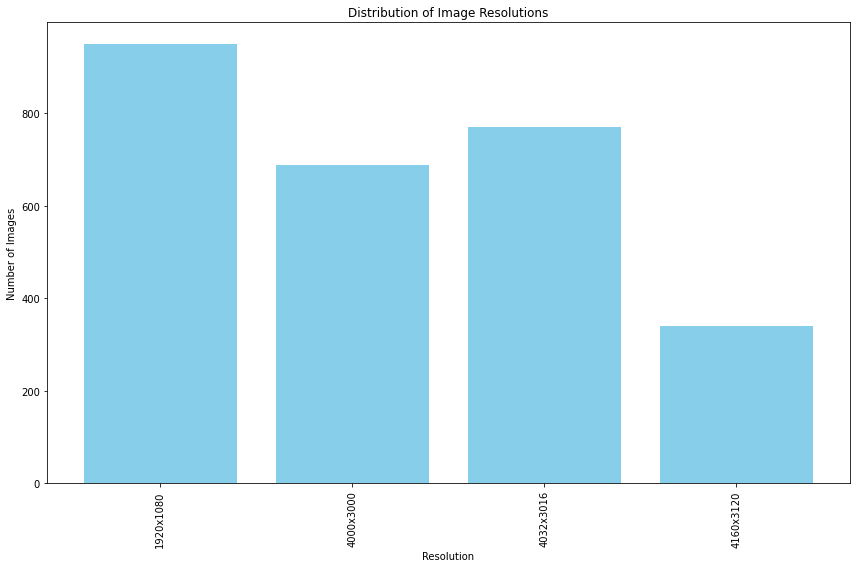

In [3]:
# Plot the distribution of image resolutions
plt.figure(figsize=(12, 8))
plt.bar(df_resolutions['Resolution'].astype(str), df_resolutions['Count'], color='skyblue')
plt.xlabel('Resolution')
plt.ylabel('Number of Images')
plt.title('Distribution of Image Resolutions')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

We notice that the resolutions aren't the same and most of the images are 1920x1080, i have checked the images resolutions to narrow down the object detection model selection, and how big the model should be. 

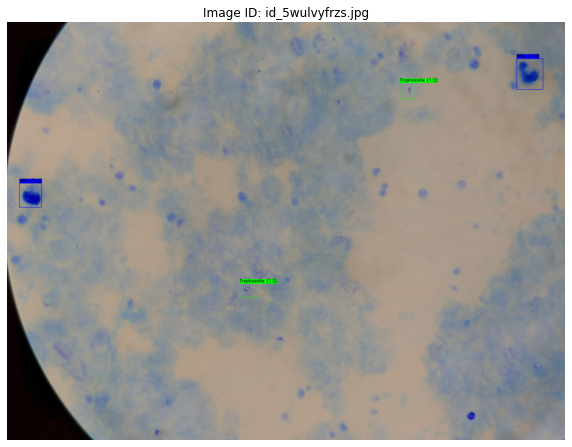

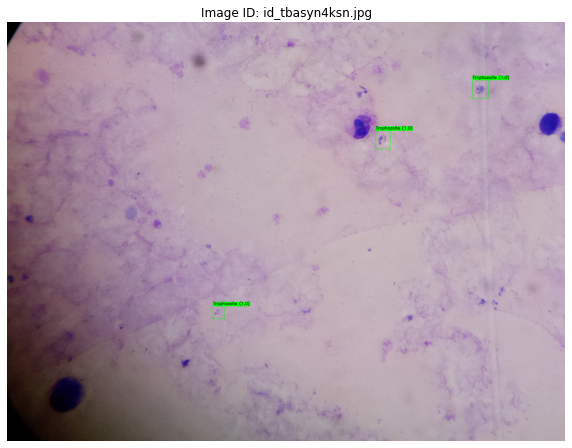

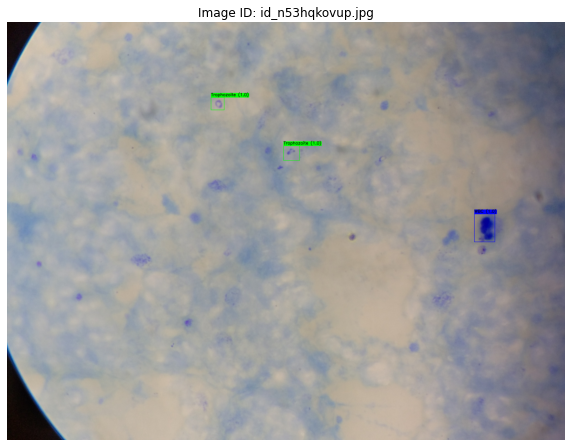

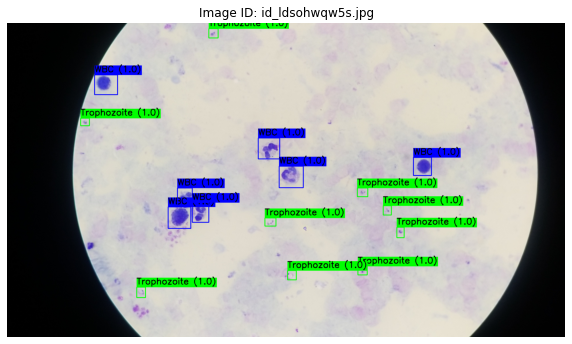

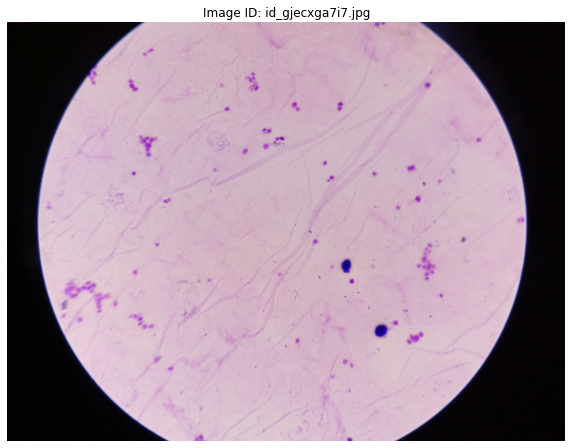

In [7]:
# Paths
image_dir = '/home/walid/Desktop/OpenCv/Malaria-detection/train'
train_csv_path = '/home/walid/Desktop/OpenCv/Malaria-detection/Train.csv'

# Read the Train.csv file
train_df = pd.read_csv(train_csv_path)

# Function to draw bounding boxes and display images
def visualize_images(df, image_dir, num_images=5):
    """
    Visualizes images with their corresponding bounding boxes.

    Parameters:
    - df (pd.DataFrame): DataFrame containing image annotations.
    - image_dir (str): Directory where images are stored.
    - num_images (int): Number of images to visualize.
    """
    # Get unique image IDs
    unique_image_ids = df['Image_ID'].unique()
    
    # Ensure num_images does not exceed the number of available images
    num_images = min(num_images, len(unique_image_ids))
    
    # Randomly select a subset of image IDs
    sample_image_ids = random.sample(list(unique_image_ids), num_images)
    
    for image_id in sample_image_ids:
        image_path = os.path.join(image_dir, image_id)
        image = cv2.imread(image_path)
        
        if image is not None:
            # Get all bounding boxes for this image
            boxes = df[df['Image_ID'] == image_id]
            
            for _, row in boxes.iterrows():
                class_label = row['class']
                confidence = row['confidence']
                ymin, xmin, ymax, xmax = int(row['ymin']), int(row['xmin']), int(row['ymax']), int(row['xmax'])
                
                # Choose color based on class
                if class_label == 'Trophozoite':
                    color = (0, 255, 0)  # Green
                elif class_label == 'WBC':
                    color = (255, 0, 0)  # Blue
                elif class_label == 'NEG':
                    color = (0, 0, 255)  # Red
                else:
                    color = (255, 255, 0)  # Cyan for unknown classes
                
                # Draw the bounding box
                cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
                
                # Prepare label with class and confidence
                label = f"{class_label} ({confidence})"
                
                # Increase the font scale and thickness for larger labels
                font_scale = 1.0  # Larger font size
                font_thickness = 2  # Thicker text
                
                # Calculate text size for background rectangle
                (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
                
                # Draw background rectangle for text
                cv2.rectangle(image, (xmin, ymin - text_height - baseline), 
                                      (xmin + text_width, ymin), color, -1)
                
                # Put the label text above the bounding box
                cv2.putText(image, label, (xmin, ymin - baseline), 
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness)
            
            # Convert image from BGR (OpenCV format) to RGB (matplotlib format)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Display the image with bounding boxes
            plt.figure(figsize=(10, 10))
            plt.imshow(image_rgb)
            plt.title(f"Image ID: {image_id}")
            plt.axis('off')
            plt.show()
        else:
            print(f"Image {image_id} not found.")

# Visualize a sample of images with bounding boxes
visualize_images(train_df, image_dir, num_images=5)


In [2]:
!nvidia-smi

Tue Aug 27 16:40:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   61C    P3             18W /   50W |     578MiB /   4096MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Load the CSV file
csv_file = '/home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/Train.csv'
train_df = pd.read_csv(csv_file)

# Check for unique classes in the 'class' column
unique_classes = train_df['class'].unique()
print("Unique classes found:", unique_classes)


Unique classes found: ['Trophozoite' 'NEG' 'WBC']


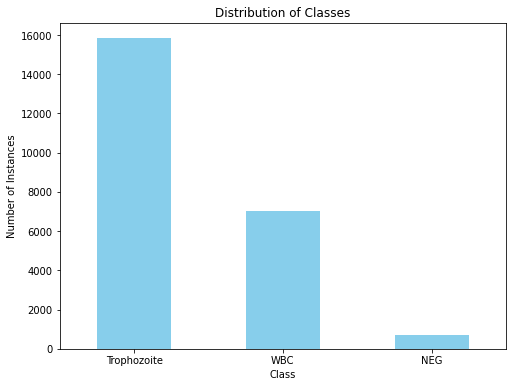

In [6]:
# Count the occurrences of each class
class_counts = train_df['class'].value_counts()

# Plot the distribution of classes
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()


We notice that the classes are unbalanced 

Let's Prepare the data for the yolo model

In [9]:
import yaml

# Define dataset paths
dataset_root = '/home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge'  # Replace with the actual path to your dataset
train_images_dir = 'images/train'  # Replace with the actual relative path to your training images
val_images_dir = 'images/val'      # Replace with the actual relative path to your validation images
test_images_dir = 'images/test'    # Replace with the actual relative path to your test images, if applicable

# Map the unique classes to indices
# Sort unique classes to ensure they are in ascending order
sorted_classes = sorted(unique_classes)

# Map the unique classes to indices
class_map = {idx: class_name for idx, class_name in enumerate(sorted_classes)}

# Prepare the data.yaml dictionary
data_yaml = {
    'path': dataset_root,
    'train': train_images_dir,
    'val': val_images_dir,
    'test': test_images_dir,  # Optional, can be left blank if not available
    'names': class_map
}

# Define the output path for data.yaml
yaml_output_path = '/home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/data.yaml'

# Write the data.yaml file
with open(yaml_output_path, 'w') as yaml_file:
    yaml.dump(data_yaml, yaml_file, default_flow_style=False)

print(f"data.yaml file created successfully at {yaml_output_path}")


data.yaml file created successfully at /home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/data.yaml


# Creating YOLO Supported Dataset Formats

In [11]:
import shutil

# Paths
csv_file = '/home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/Train.csv'
images_dir = '/home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/images'
output_images_dir = '/home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/processed_images'
output_labels_dir = '/home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/processed_labels'

# Create directory structure
os.makedirs(os.path.join(output_images_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_images_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_labels_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_labels_dir, 'val'), exist_ok=True)

# Load the CSV file
train_df = pd.read_csv(csv_file)

# Define class mapping
class_mapping = {cls: idx for idx, cls in enumerate(sorted(train_df['class'].unique()))}

# Split the data into train and val sets (80% train, 20% val)
train_ids = train_df['Image_ID'].unique()
np.random.shuffle(train_ids)
split_index = int(0.8 * len(train_ids))
train_ids, val_ids = train_ids[:split_index], train_ids[split_index:]

# Define function to convert bounding boxes to YOLO format
# Box coordinates must be in normalized xywh format (from 0 to 1)
def convert_bbox_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height):
    x_center = (xmin + xmax) / 2 / img_width
    y_center = (ymin + ymax) / 2 / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    return x_center, y_center, width, height

# Process images and annotations
for image_id in train_ids:
    image_path = os.path.join(images_dir, image_id)
    txt_filename = os.path.join(output_labels_dir, 'train', os.path.splitext(image_id)[0] + '.txt')
    target_image_path = os.path.join(output_images_dir, 'train', image_id)
    
    # Check if the image file exists
    if not os.path.isfile(image_path):
        print(f"Warning: {image_id} could not be found.")
        continue

    # Copy the image to the new location
    shutil.copy(image_path, target_image_path)

    # Load image to get dimensions
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: {image_id} could not be read.")
        continue

    img_height, img_width, _ = image.shape

    # Create YOLO format annotations
    with open(txt_filename, 'w') as txt_file:
        for _, row in train_df[train_df['Image_ID'] == image_id].iterrows():
            if row['class'] == 'NEG':
                continue
            
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            x_center, y_center, width, height = convert_bbox_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height)
            class_id = class_mapping[row['class']]
            txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    print(f"Processed {image_id} for training.")

for image_id in val_ids:
    image_path = os.path.join(images_dir, image_id)
    txt_filename = os.path.join(output_labels_dir, 'val', os.path.splitext(image_id)[0] + '.txt')
    target_image_path = os.path.join(output_images_dir, 'val', image_id)
    
    # Check if the image file exists
    if not os.path.isfile(image_path):
        print(f"Warning: {image_id} could not be found.")
        continue

    # Copy the image to the new location
    shutil.copy(image_path, target_image_path)

    # Load image to get dimensions
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: {image_id} could not be read.")
        continue

    img_height, img_width, _ = image.shape

    # Create YOLO format annotations
    with open(txt_filename, 'w') as txt_file:
        for _, row in train_df[train_df['Image_ID'] == image_id].iterrows():
            if row['class'] == 'NEG':
                continue
            
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            x_center, y_center, width, height = convert_bbox_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height)
            class_id = class_mapping[row['class']]
            txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    print(f"Processed {image_id} for validation.")

print("Data processing complete!")


Processed id_tytvx6k5jv.jpg for training.
Processed id_1bcb81j5jv.jpg for training.
Processed id_bj8z20mdd8.jpg for training.
Processed id_calvvsgfft.jpg for training.
Processed id_jsfiseoilv.jpg for training.
Processed id_qg95y3rm5q.jpg for training.
Processed id_dl2kaag27a.jpg for training.
Processed id_bjdisdomjc.jpg for training.
Processed id_ytf1wlvfh4.jpg for training.
Processed id_vkqsqn50v7.jpg for training.
Processed id_wjud0pq2bq.jpg for training.
Processed id_wqupiztnka.jpg for training.
Processed id_8ken1mdqby.jpg for training.
Processed id_oeg81pq0yc.jpg for training.
Processed id_9qtfjptkch.jpg for training.
Processed id_vvyak3qdrk.jpg for training.
Processed id_bwskj8f0oq.jpg for training.
Processed id_90egdm0iiy.jpg for training.
Processed id_sb3xh1b13r.jpg for training.
Processed id_25o9h1nijh.jpg for training.
Processed id_zytohx1ml2.jpg for training.
Processed id_gdm8100m5w.jpg for training.
Processed id_iisyobbs2a.jpg for training.
Processed id_wy64v158ve.jpg for tr

In [12]:
!pip install ultralytics

In [1]:
from ultralytics import YOLO
 
# Load the model.
baseline_model = YOLO('yolov8n.pt')
 
# Training.
results = baseline_model.train(
   data='data.yaml',
   imgsz=1280,
   epochs=20,
   batch=8,
   name='yolov8n_v0'
)

New https://pypi.org/project/ultralytics/8.2.82 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.172 🚀 Python-3.8.10 torch-1.12.0+cu102 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 3897MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=20, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v0, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stre

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.81 GiB total capacity; 2.45 GiB already allocated; 43.31 MiB free; 2.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Let's test our model on the test data set 


In [9]:
from ultralytics import YOLO
import pandas as pd

# Load the trained model
model = YOLO('runs/detect/yolov8n_v04/weights/best.pt')

# Directory containing test images
test_dir = 'test/'

# Run predictions
results = model.predict(source=test_dir, save_txt=False, save_conf=True, stream=True)

# Initialize an empty list to store the rows for the submission file
submission_data = []

# Iterate over the results
for result in results:
    image_id = result.path.split('/')[-1]  # Extract the image ID (filename)
    
    # Check if there are any detections
    if result.boxes:  # If there are any bounding boxes
        for box in result.boxes:
            # Extract the necessary information from each bounding box
            class_name = result.names[int(box.cls)]  # Class name
            confidence = box.conf.item()  # Confidence score
            xmin, ymin, xmax, ymax = box.xyxy[0].tolist()  # Bounding box coordinates

            # Append a row for each detection
            submission_data.append([image_id, class_name, confidence, ymin, xmin, ymax, xmax])
    else:
        # If no detections, add a default entry for the image with 'NEG' class
        submission_data.append([image_id, 'NEG', 0.5, 0, 0, 0, 0])

# Create a DataFrame from the collected data
submission_df = pd.DataFrame(submission_data, columns=['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax'])

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully: submission.csv")



image 1/1178 /home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/test/id_02i83lum2m.jpg: 480x640 5 Trophozoites, 7 WBCs, 7.0ms
image 2/1178 /home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/test/id_02kpdbnrfn.jpg: 480x640 5 Trophozoites, 9 WBCs, 6.9ms
image 3/1178 /home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/test/id_03e6tz6thd.jpg: 480x640 7 Trophozoites, 1 WBC, 6.4ms
image 4/1178 /home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/test/id_04g5qzuv79.jpg: 384x640 2 WBCs, 6.0ms
image 5/1178 /home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/test/id_04z71hekrh.jpg: 384x640 10 Trophozoites, 3 WBCs, 6.7ms
image 6/1178 /home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/test/id_052gicowtk.jpg: 384x640 6 Trophozoites, 6 WBCs, 5.3ms
image 7/1178 /home/walid/Desktop/OpenCv/Lacuna-Malaria-Detection-Challenge/test/id_06yg7qkp5p.jpg: 384x640 3 Trophozoites, 1 WBC, 5.3ms
image 8/1178 /home/walid/Desktop/OpenCv/Lacuna-Malaria-De

Submission file created successfully: submission.csv


## YOLOv8 Notes

I took a deep dive into YOLO's structure and how state-of-the-art (SOTA) object detection works. Here are the important concepts:

### Anchor Boxes
Redefined bounding boxes of specific shapes and sizes that help the model detect objects at various scales and aspect ratios.

### Fine-Tuning vs. Retraining
- **Fine-Tuning**: Adjusting a pre-trained model to new data.
- **Retraining**: Starting a model from scratch with random weights.

### Hyperparameter Tuning for YOLOv8
Use the available YOLO tuner, which employs a mutating algorithm to find the best parameters.

### Augmentation
Augmentation techniques are used to artificially expand the training dataset and improve model generalization. Common augmentations include:
- **HSV (Hue, Saturation, Value) Adjustments**: Modifying the color properties of images.
- **Rotation**: Rotating images by a certain angle.
- **Translation**: Shifting images along the x and y axes.
- **Scaling**: Resizing images to create different scales.
- **Shear**: Applying shearing transformations to images.
- **Perspective**: Applying perspective transformations to images.
- **Flipping**: Flipping images horizontally or vertically.
- **Mixup**: Combining multiple images to create new training samples.
- **Mosaic**: Mixing multiple images into a single image to improve robustness.

These techniques help the model to be more robust and perform better in various conditions.